## Sentiment Classification

Sentiment classification automates the task of detecting and categorizing emotions in text into positive, negative, or neutral categories, based on the expressed opinions. This process, which leverages Natural Language Processing (NLP), is crucial for understanding customer perceptions and emotions about your brand, products, and services.

Manually sifting through and categorizing textual data is time-consuming and can distract from capturing key insights due to the tedious nature of manual analysis of positive and negative sentiments.

In recent years, sentiment classification has experienced significant growth and adoption across various industries. Many companies now rely on this technology to gain deeper insights into their customers’ emotions, behaviors, preferences, and needs.

Automated classification techniques allow for quicker analysis of reviews, comments, survey responses, and other forms of public feedback. These methods efficiently assess the general sentiment towards your brand and products, providing valuable insights into broader industry trends and market dynamics.

### Recurrent Neural Network (RNN)

A recurrent neural network (RNN) is particularly effective with sequential data, making it well-suited for processing text, which inherently consists of word sequences. In this context, we'll employ an LSTM (Long Short-Term Memory) network, a specialized form of RNN, to tackle a sentiment classification challenge using movie reviews.

An LSTM unit is composed of a cell and three gates: an input gate, an output gate, and a forget gate. The cell is capable of maintaining information over extended periods, while the gates control the flow of information into and out of the cell, helping manage memory in the network.

LSTM networks are ideal for handling classification tasks involving time series data and are adept at overcoming issues like exploding and vanishing gradients, which are common pitfalls in training conventional RNNs.

<img style="-webkit-user-select: none;margin: auto;" src="RNN.png" width="500" height="250">








## Dataset Description

The dataset used in this experiment is the [IMDB movie review](http://ai.stanford.edu/~amaas/data/sentiment/) dataset. This dataset for binary sentiment classification contains around 50k movie reviews with the following attributes:

* **review:** text based review of each movie
* **sentiment:** positive or negative sentiment value


### Importing Required Libraries

In [41]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from bs4 import BeautifulSoup          # BeautifulSoup is a useful library for extracting data from HTML and XML documents
from numpy import array
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Activation, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, GlobalMaxPooling1D, Dense, Embedding, LSTM, GRU
import pandas.testing as tm

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nandu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nandu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Load the Dataset

In [42]:
movie_reviews = pd.read_csv("IMDB_Dataset.csv")

### Exploratory Data Analysis

In [43]:
# Check the shape of the data
movie_reviews.shape

(50000, 2)

In [44]:
movie_reviews.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [45]:
# Check for null Values
movie_reviews.isnull().sum()

review       0
sentiment    0
dtype: int64

In [46]:
# Let us view one of the reviews
movie_reviews["review"][5]

'Probably my all-time favorite movie, a story of selflessness, sacrifice and dedication to a noble cause, but it\'s not preachy or boring. It just never gets old, despite my having seen it some 15 or more times in the last 25 years. Paul Lukas\' performance brings tears to my eyes, and Bette Davis, in one of her very few truly sympathetic roles, is a delight. The kids are, as grandma says, more like "dressed-up midgets" than children, but that only makes them more fun to watch. And the mother\'s slow awakening to what\'s happening in the world and under her own roof is believable and startling. If I had a dozen thumbs, they\'d all be "up" for this movie.'

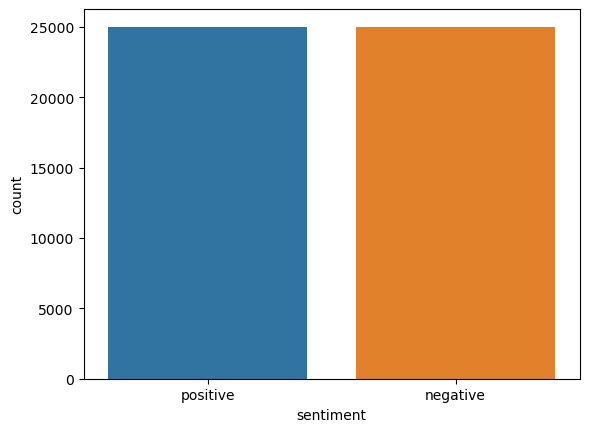

In [47]:
# View the distribution of positive and negative sentiments in the dataset
sns.countplot(x='sentiment', data = movie_reviews)
plt.show()

We can see above that there are an equal number of positive and negative sentiment reviews in the dataset.

## Data Preprocessing

Remove any html tags, punctuations, special characters, stopwords etc. from the review text.

- **Remove HTML, XML, etc.**


In [48]:
# removing the html strips
def strip_html(text):
    # BeautifulSoup is a useful library for extracting data from HTML and XML documents
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

In [49]:
movie_reviews['review'] = movie_reviews['review'].apply(strip_html)

C:\Users\nandu\anaconda3\envs\eee4773\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [53]:
# Let us view one of the reviews
movie_reviews["review"][5]

'Probably my alltime favorite movie story of selflessness sacrifice and dedication to noble cause but its not preachy or boring It just never gets old despite my having seen it some 15 or more times in the last 25 years Paul Lukas performance brings tears to my eyes and Bette Davis in one of her very few truly sympathetic roles is delight The kids are as grandma says more like dressedup midgets than children but that only makes them more fun to watch And the mothers slow awakening to whats happening in the world and under her own roof is believable and startling If had dozen thumbs theyd all be up for this movie'

- **Remove punctuations**

In [54]:
# removing punctuations
def remove_punctuations(text):

    pattern = r'[^a-zA-Z0-9\s]'
    text = re.sub(pattern,'',text)

    # Single character removal
    text = re.sub(r"\s+[a-zA-Z]\s+", ' ', text)

    # Removing multiple spaces
    text = re.sub(r'\s+', ' ', text)

    return text

In [55]:
# Remove puntuations
movie_reviews['review'] = movie_reviews['review'].apply(remove_punctuations)

In [56]:
# Let us view one of the reviews
movie_reviews["review"][5]

'Probably my alltime favorite movie story of selflessness sacrifice and dedication to noble cause but its not preachy or boring It just never gets old despite my having seen it some 15 or more times in the last 25 years Paul Lukas performance brings tears to my eyes and Bette Davis in one of her very few truly sympathetic roles is delight The kids are as grandma says more like dressedup midgets than children but that only makes them more fun to watch And the mothers slow awakening to whats happening in the world and under her own roof is believable and startling If had dozen thumbs theyd all be up for this movie'

**Removing stopwords**

Stopwords are English words that do not add much meaning to a sentence. They can safely be ignored without sacrificing the meaning of the sentence. For example, the words like the, he, have etc.

In [57]:
# setting english stopwords
stopword_list = nltk.corpus.stopwords.words('english')
print(stopword_list)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

The above list of stopwords also contains the word "not", and its other forms such as don't, didn't, etc. We need them for correct sentiment classification.

For example, consider a negative review "*not a good movie*", and if we remove 'not' from it then it becomes a positive review "*a good movie*".

In [58]:
# Exclude 'not' and its other forms from the stopwords list

updated_stopword_list = []

for word in stopword_list:
    if word=='not' or word.endswith("n't"):
        pass
    else:
        updated_stopword_list.append(word)

print(updated_stopword_list)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'only', 'own', 'same', 'so', 'than', 'too', '

In [59]:
# removing the stopwords
def remove_stopwords(text, is_lower_case=False):
    # splitting strings into tokens (list of words)
    tokens = nltk.tokenize.word_tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        # filtering out the stop words
        filtered_tokens = [token for token in tokens if token not in updated_stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in updated_stopword_list]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

In [60]:
# Apply function on review column
movie_reviews['review'] = movie_reviews['review'].apply(remove_stopwords)

In [61]:
# Let us view one of the reviews
movie_reviews["review"][5]

'Probably alltime favorite movie story selflessness sacrifice dedication noble cause not preachy boring never gets old despite seen 15 times last 25 years Paul Lukas performance brings tears eyes Bette Davis one truly sympathetic roles delight kids grandma says like dressedup midgets children makes fun watch mothers slow awakening whats happening world roof believable startling dozen thumbs theyd movie'

In [62]:
movie_reviews.head()

,review,sentiment
0,One reviewers mentioned watching 1 Oz episode ...,positive
1,wonderful little production filming technique ...,positive
2,thought wonderful way spend time hot summer we...,positive
3,Basically theres family little boy Jake thinks...,negative
4,Petter Matteis Love Time Money visually stunni...,positive


In [63]:
# Convert sentiment labels to integers

movie_reviews['sentiment'] = movie_reviews['sentiment'].apply(lambda x: 1 if x=="positive" else 0)

In [64]:
movie_reviews.head()

,review,sentiment
0,One reviewers mentioned watching 1 Oz episode ...,1
1,wonderful little production filming technique ...,1
2,thought wonderful way spend time hot summer we...,1
3,Basically theres family little boy Jake thinks...,0
4,Petter Matteis Love Time Money visually stunni...,1


In [65]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(movie_reviews['review'].values, movie_reviews['sentiment'].values,
                                                    test_size=0.20,
                                                    random_state=42)
len(X_train), len(X_test), len(y_train), len(y_test)

(40000, 10000, 40000, 10000)

## Prepare the Embedding Layer

The embedding layer converts our textual data into numeric data and is used as the first layer for the deep learning models in Keras

In [66]:
# Tokenizer class from the keras.preprocessing.text module creates a word-to-index dictionary
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train_tok = tokenizer.texts_to_sequences(X_train)
X_test_tok = tokenizer.texts_to_sequences(X_test)

The X_train set contains 40,000 lists of integers, each list corresponding to the sentences in a review. Set the maximum length of each list to 100 and add 0 padding to those lists that have a length $\lt$100, until they reach a length of 100.

In [67]:
# Find the vocabulary size and perform padding on both train and test set
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

X_train_pad = pad_sequences(X_train_tok, padding='post', maxlen=maxlen, truncating='post')
X_test_pad = pad_sequences(X_test_tok, padding='post', maxlen=maxlen, truncating='post')

In [68]:
print ('number of unique words in the corpus:', vocab_size)

number of unique words in the corpus: 192022


### Build LSTM Model for Text classification

In [69]:
EMBEDDING_DIM = 32

print('Build model...')

model = Sequential()
model.add(Embedding(input_dim = vocab_size, output_dim = EMBEDDING_DIM, input_length=maxlen))
model.add(LSTM(units=40,  dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

# Try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print('Summary of the built model...')
print(model.summary())

Build model...
Summary of the built model...
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 32)           6144704   
                                                                 
 lstm_1 (LSTM)               (None, 40)                11680     
                                                                 
 dense_1 (Dense)             (None, 1)                 41        
                                                                 
Total params: 6,156,425
Trainable params: 6,156,425
Non-trainable params: 0
_________________________________________________________________
None


### Training and Validation

In [72]:
history = model.fit(X_train_pad, y_train, batch_size=128, epochs=3, verbose=1, validation_split=0.2)

Epoch 1/3
250/250 [==============================] - 28s 105ms/step - loss: 0.4934 - accuracy: 0.7414 - val_loss: 0.3278 - val_accuracy: 0.8674
Epoch 2/3
250/250 [==============================] - 30s 119ms/step - loss: 0.3026 - accuracy: 0.8804 - val_loss: 0.3169 - val_accuracy: 0.8708
Epoch 3/3
250/250 [==============================] - 30s 121ms/step - loss: 0.2643 - accuracy: 0.8972 - val_loss: 0.3415 - val_accuracy: 0.8662


In [73]:
# Save the model
model.save('my_model.h5')

print("Model saved successfully!")

Model saved successfully!


### Model Performance

In [74]:
print('Testing...')
y_test = np.array(y_test)
score, acc = model.evaluate(X_test_pad, y_test, batch_size=128)

print('Test score:', score)
print('Test accuracy:', acc)

print("Accuracy: {0:.2%}".format(acc))

Testing...
79/79 [==============================] - 1s 18ms/step - loss: 0.3362 - accuracy: 0.8632
Test score: 0.33623525500297546
Test accuracy: 0.8632000088691711
Accuracy: 86.32%


### Predict a few more samples

In [80]:
# Additional test samples
test_samples = [
    "Absolutely loved the cinematography in this film!",
    "The plot was predictable and boring.",
    "What an amazing performance by the lead actor!",
    "I wouldn’t recommend this movie to anyone.",
    "A delightful gem of a film that brought joy.",
    "The movie was too long and dragged in the middle.",
    "An uninspiring script with lackluster direction.",
    "It’s a masterpiece, with brilliant twists and turns.",
    "Bad movie!",
    "Not a good movie!"
]

# Tokenize and pad new combined test samples
all_test_samples_tokens = tokenizer.texts_to_sequences(test_samples)
all_test_samples_tokens_pad = pad_sequences(all_test_samples_tokens, maxlen=maxlen)

# Predict sentiments for the new combined test samples
all_preds = model.predict(x=all_test_samples_tokens_pad)

# Output predictions
print(all_preds)


1/1 [==============================] - 0s 32ms/step
[[0.7644737 ]
 [0.44086105]
 [0.76656854]
 [0.72349924]
 [0.9164799 ]
 [0.70296556]
 [0.5364148 ]
 [0.88134   ]
 [0.5911534 ]
 [0.68513125]]


The values close to 1 represents `positive` sentiment, and values close to 0 represents `negative` sentiment.